In [1]:
import numpy as np
import pandas as pd
import scipy.io
from scipy import special
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import plotly.express as px
from datetime import date
from glob import glob
from os.path import join, exists
import random
from random import random as rand

from datetime import date

from tqdm import tqdm

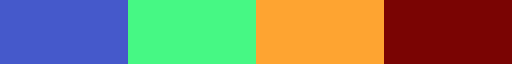

In [2]:
from matplotlib import cm, colors

tmp = cm.turbo(np.linspace(0.1,1.0,4))
palette = [colors.rgb2hex(rgb, keep_alpha=False) for rgb in tmp]

colors.ListedColormap(palette)

In [3]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

In [4]:
%config InlineBackend.figure_format = 'retina'
py.offline.init_notebook_mode(connected = True)

In [5]:
np.set_printoptions(precision=5, suppress=True)

In [6]:
dir_root = '/mnt/ext5/GP'

In [7]:
def convert_ID(ID):
    ##################   ##################
    #  1  2  3  4  5 #   #        2       #
    #  6  7  8  9 10 #   #        1       #
    # 11 12 13 14 15 # = # -2 -1  0  1  2 #
    # 16 17 18 19 20 #   #       -1       #
    # 21 22 23 24 25 #   #       -2       #
    ##################   ##################
    x = np.kron(np.ones(5),np.arange(-2,3)).astype(int)
    y = np.kron(np.arange(2,-3,-1),np.ones(5)).astype(int)
    pos = np.array((x[ID-1],y[ID-1]))
    return pos

In [8]:
def calc_hit(file_behav, tpr=97, nrun=6):
    ##### parameters #####
    ## file_behav: 불러올 .mat 파일 경로
    ## tpr: trial per run, default=97 (GA project)
    ## nrun: 불러올 run 수, 예) nrun=4 일 경우, r01~r04 까지 데이터를 불러옴
    
    datum = scipy.io.loadmat(file_behav)
    
    ## frame per trial
    fpt = int(datum['nSampleTrial'][0][0])
    ## second per trial
    spt = int(fpt/60.)
    ## a number of trials per run
    # tpr = datum['nTrialperRun'][0][0]
#     tpr = 97  # 12 trial/block * 8 block/run + 1 = 97 trial/run

    ## target ID
    tmp = datum['targetID'][0]
    targetID = tmp[tmp!=0][:tpr*nrun]

    bx = datum['boxSize'][0][0]
    pos = bx*convert_ID(targetID)
    
    ## 60 Hz * {5 s/trial * (1 trial + 12 trial/block * 8 block)}/Run * 3 Run = 87300
    allXY = datum['allXY']
    
    xFrame, yFrame = np.array([datum['xFrame'].squeeze(), datum['yFrame'].squeeze()]).astype(int)
    
    ## target position
    tmp = np.zeros(allXY.shape)
    for i in range(fpt*tpr*nrun):
        t = np.floor(i/fpt).astype(int)
        tmp[0][i], tmp[1][i] = pos[0][t], pos[1][t]

    ## Is it hit?
    err = allXY - tmp
    hit = np.zeros(fpt*tpr*nrun)
    for i in range(fpt*tpr*nrun):
        hit[i] = abs(err[0][i]) <= bx*.5 and abs(err[1][i]) <= bx*.5
        
    return hit

## GA

In [9]:
dir_work = '/home/sungbeenpark/Github/labs/GA'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-fmri.mat')))

df_GA = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*6)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GA.loc[i]['subj'] = subj
    df_GA.loc[i]['group'] = 'GA'
    hit = calc_hit(fname, tpr=97)
    for block in range(8*6):
        run = block // 8 + 1
        df_GA.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GA

100%|██████████| 30/30 [00:34<00:00,  1.16s/it]


,subj,group,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,GA01,GA,0.225833,0.221389,0.370833,0.316389,0.341389,0.389444,0.266667,0.379444,...,0.429167,0.43,0.3975,0.405,0.263889,0.265833,0.33,0.223333,0.338611,0.304722
1,GA02,GA,0.382778,0.487222,0.434722,0.219167,0.381111,0.498611,0.438333,0.391944,...,0.43,0.453611,0.36,0.458611,0.542222,0.489167,0.498611,0.498056,0.573889,0.533611
2,GA05,GA,0.040556,0.402222,0.246389,0.094167,0.221667,0.204167,0.045,0.206944,...,0.216111,0.394722,0.395556,0.446389,0.453333,0.299167,0.435556,0.452778,0.375833,0.531389
3,GA07,GA,0.146389,0.240833,0.07,0.1925,0.293056,0.286111,0.257222,0.196944,...,0.617778,0.565833,0.543333,0.374167,0.544167,0.540278,0.556667,0.598333,0.480278,0.5275
4,GA08,GA,0.263889,0.233056,0.411667,0.432222,0.258056,0.673889,0.530833,0.488611,...,0.348056,0.330556,0.437778,0.4675,0.421111,0.240556,0.444167,0.460556,0.348889,0.489722
5,GA11,GA,0.043611,0.206389,0.144722,0.168611,0.27,0.231111,0.255,0.241111,...,0.341389,0.4,0.335833,0.410278,0.235278,0.244444,0.264722,0.343056,0.343889,0.290556
6,GA12,GA,0.132222,0.1525,0.167222,0.368333,0.107778,0.115,0.289167,0.252778,...,0.439167,0.394167,0.365278,0.260556,0.492222,0.393889,0.335,0.450278,0.342222,0.440556
7,GA13,GA,0.135833,0.254444,0.338333,0.197778,0.2525,0.346389,0.458056,0.305,...,0.441111,0.640278,0.479722,0.466667,0.494444,0.605,0.432222,0.582222,0.532778,0.518333
8,GA14,GA,0.121944,0.128056,0.136944,0.138889,0.281667,0.16,0.0825,0.138056,...,0.186389,0.196389,0.076111,0.123611,0.2225,0.235833,0.236667,0.270833,0.311667,0.255
9,GA15,GA,0.108333,0.205278,0.293056,0.185556,0.237222,0.171389,0.233611,0.2225,...,0.648056,0.694167,0.556111,0.631389,0.660278,0.683333,0.665556,0.687778,0.682222,0.645


In [10]:
dir_work = '/home/sungbeenpark/Github/labs/GA'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-refmri.mat')))

df_GB = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*6)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GB.loc[i]['subj'] = subj.replace('GA','GB')
    df_GB.loc[i]['group'] = 'GB'
    hit = calc_hit(fname, tpr=97)
    for block in range(8*6):
        run = block // 8 + 1
        df_GB.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GB

100%|██████████| 30/30 [00:36<00:00,  1.23s/it]


,subj,group,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,GB01,GB,0.6625,0.800833,0.651667,0.809167,0.783333,0.798056,0.790556,0.819722,...,0.656944,0.726944,0.722222,0.710833,0.753611,0.740556,0.793056,0.739444,0.752778,0.798056
1,GB02,GB,0.731944,0.796389,0.824444,0.787778,0.803056,0.785556,0.823889,0.828333,...,0.650278,0.663611,0.644722,0.693611,0.695556,0.707778,0.639167,0.614167,0.600278,0.75
2,GB05,GB,0.508333,0.633611,0.722778,0.629722,0.694444,0.652778,0.591111,0.624167,...,0.604444,0.731667,0.437222,0.591944,0.596389,0.559444,0.537222,0.596944,0.666111,0.648889
3,GB07,GB,0.526944,0.752222,0.755,0.723611,0.709167,0.725278,0.703889,0.732222,...,0.5625,0.564722,0.622222,0.666944,0.660556,0.635556,0.700278,0.702222,0.538611,0.631111
4,GB08,GB,0.419444,0.646389,0.641389,0.565,0.718056,0.665556,0.731944,0.596667,...,0.396111,0.429444,0.428611,0.417222,0.431111,0.430278,0.483611,0.430556,0.624444,0.513056
5,GB11,GB,0.5975,0.6525,0.618889,0.605,0.555,0.576111,0.525278,0.679722,...,0.298611,0.322778,0.449444,0.390278,0.373889,0.210833,0.388889,0.412222,0.4175,0.296667
6,GB12,GB,0.562778,0.694722,0.5725,0.618056,0.6025,0.623333,0.606667,0.590833,...,0.286667,0.257222,0.319167,0.342778,0.215556,0.2025,0.354444,0.329444,0.333056,0.408333
7,GB13,GB,0.735833,0.726944,0.741111,0.696111,0.744722,0.774444,0.665278,0.6675,...,0.505278,0.383889,0.556111,0.612222,0.629722,0.5625,0.542778,0.597778,0.574167,0.526667
8,GB14,GB,0.471667,0.602778,0.605278,0.636111,0.694167,0.696389,0.639167,0.759722,...,0.42,0.542222,0.3975,0.468611,0.411111,0.520556,0.503056,0.519722,0.645556,0.61
9,GB15,GB,0.715,0.6825,0.771111,0.741667,0.731944,0.753889,0.751111,0.748056,...,0.436389,0.336667,0.431944,0.524444,0.51,0.598611,0.557778,0.593056,0.458333,0.569444


## GD

In [11]:
dir_work = '/home/sungbeenpark/Github/labs/GD'
dir_data = join(dir_work, 'behav_data')
list_behav = sorted(glob(join(dir_data, '*-refmri.mat')))

df_GD = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*6)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GD.loc[i]['subj'] = subj
    df_GD.loc[i]['group'] = 'GD'
    hit = calc_hit(fname, tpr=97)
    for block in range(8*6):
        run = block // 8 + 1
        df_GD.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GD

100%|██████████| 15/15 [00:18<00:00,  1.20s/it]


,subj,group,0,1,2,3,4,5,6,7,...,38,39,40,41,42,43,44,45,46,47
0,GD01,GD,0.185,0.477778,0.471667,0.419444,0.412778,0.5275,0.569444,0.623611,...,0.569444,0.605556,0.493889,0.589167,0.596111,0.471667,0.546667,0.637222,0.641944,0.585833
1,GD02,GD,0.570278,0.705278,0.713333,0.755833,0.799444,0.7775,0.774444,0.793889,...,0.376389,0.585278,0.632778,0.540278,0.607778,0.662778,0.668056,0.628889,0.6675,0.696389
2,GD07,GD,0.379444,0.381111,0.382222,0.514444,0.601111,0.601944,0.610833,0.561667,...,0.090833,0.358333,0.36,0.357222,0.482222,0.511389,0.391111,0.508333,0.248611,0.425
3,GD11,GD,0.176111,0.408333,0.544444,0.442778,0.447222,0.495,0.513889,0.636389,...,0.425833,0.230833,0.391111,0.316944,0.263889,0.313056,0.263333,0.352222,0.339722,0.296944
4,GD15,GD,0.206389,0.388333,0.4,0.476944,0.344444,0.5675,0.570556,0.591389,...,0.278333,0.300278,0.500556,0.670278,0.694722,0.511111,0.706667,0.689167,0.752222,0.735278
5,GD20,GD,0.224444,0.385833,0.373333,0.418889,0.455278,0.5325,0.413056,0.423611,...,0.418333,0.396667,0.3375,0.389167,0.39,0.343611,0.394722,0.381389,0.391667,0.435
6,GD23,GD,0.699722,0.670833,0.681389,0.723056,0.713889,0.660833,0.548056,0.650833,...,0.6225,0.544444,0.550833,0.556667,0.671389,0.345278,0.558056,0.57,0.607222,0.680833
7,GD26,GD,0.553056,0.436111,0.480833,0.507778,0.551389,0.565556,0.570556,0.4825,...,0.696667,0.689444,0.660833,0.752222,0.639167,0.745278,0.763611,0.760556,0.729167,0.73
8,GD29,GD,0.281389,0.145,0.133333,0.178056,0.166389,0.091944,0.132222,0.136111,...,0.441111,0.478056,0.415278,0.438889,0.443611,0.5175,0.590278,0.408333,0.609444,0.616389
9,GD30,GD,0.553611,0.691111,0.741389,0.728889,0.760833,0.730833,0.733333,0.816389,...,0.564167,0.552778,0.615278,0.506667,0.601111,0.654444,0.604722,0.525833,0.590556,0.602778


## GP

In [12]:
list_dlPFC_cTBS = [
    '09', '10', '18', '21', '22'
    , '24', '27', '34', '35', '36'
    , '38', '42', '57', '59', '62'
    , '66', '67'
]
list_M1_cTBS = [
    '08', '11', '17', '19', '20'
    , '26', '32', '33', '37', '39'
    , '40', '41', '56', '58', '61'
    , '63', '65'
]
list_dlPFC_20Hz = [
    '43', '44', '45', '46', '47'
    , '48', '49', '50', '51', '53'
    , '54', '55'
]

- GP_DLPFC

In [13]:
dir_data = join(dir_root, 'behav_data')

list_behav = []
for s in list_dlPFC_cTBS:
    list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
df_GP_dlpfc = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GP_dlpfc.loc[i]['subj'] = subj
    df_GP_dlpfc.loc[i]['group'] = 'GP_dlPFC_cTBS'
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GP_dlpfc.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GP_dlpfc

100%|██████████| 17/17 [00:09<00:00,  1.74it/s]


,subj,group,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,GP09,GP_dlPFC_cTBS,0.095278,0.006389,0.145833,0.107222,0.157222,0.038056,0.132222,0.089444,...,0.180833,0.188889,0.3575,0.069444,0.072222,0.146667,0.169722,0.235,0.208611,0.214722
1,GP10,GP_dlPFC_cTBS,0.082222,0.167222,0.152222,0.1375,0.251389,0.201944,0.1525,0.150278,...,0.194722,0.281944,0.198611,0.273333,0.129167,0.238333,0.224722,0.211944,0.377778,0.420833
2,GP18,GP_dlPFC_cTBS,0.013611,0.109722,0.098056,0.218056,0.339722,0.181389,0.228333,0.180278,...,0.174167,0.174722,0.303056,0.160278,0.179722,0.1575,0.112222,0.033333,0.064722,0.1125
3,GP21,GP_dlPFC_cTBS,0.032778,0.062222,0.0,0.099167,0.001944,0.071944,0.046389,0.024722,...,0.376667,0.493056,0.546111,0.5175,0.598333,0.599444,0.563333,0.561667,0.584444,0.54
4,GP22,GP_dlPFC_cTBS,0.149167,0.131667,0.164722,0.235556,0.351389,0.303333,0.200556,0.400278,...,0.241667,0.268056,0.478889,0.451944,0.505833,0.476667,0.543056,0.535833,0.505556,0.566111
5,GP24,GP_dlPFC_cTBS,0.065833,0.116944,0.085556,0.009722,0.159167,0.051389,0.157778,0.230833,...,0.442222,0.683333,0.493889,0.783611,0.691944,0.753333,0.665556,0.686667,0.663056,0.544722
6,GP27,GP_dlPFC_cTBS,0.008611,0.107222,0.207778,0.1825,0.206389,0.409167,0.305556,0.300833,...,0.538056,0.418889,0.548889,0.649722,0.354444,0.464167,0.515833,0.500833,0.615833,0.611944
7,GP34,GP_dlPFC_cTBS,0.011111,0.001944,0.136944,0.283889,0.357222,0.286667,0.352778,0.3575,...,0.330278,0.393889,0.4675,0.536667,0.569444,0.543056,0.574444,0.586944,0.598611,0.473889
8,GP35,GP_dlPFC_cTBS,0.07,0.198889,0.085,0.230556,0.375,0.360278,0.504722,0.427222,...,0.66,0.5775,0.630278,0.301111,0.343056,0.4075,0.457778,0.611389,0.346667,0.536111
9,GP36,GP_dlPFC_cTBS,0.144444,0.196111,0.2,0.076111,0.214444,0.349722,0.171389,0.266111,...,0.349167,0.451667,0.419722,0.431667,0.433056,0.471944,0.605833,0.537222,0.546944,0.552222


- GP_M1

In [14]:
dir_data = join(dir_root, 'behav_data')

list_behav = []
for s in list_M1_cTBS:
    list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
df_GP_m1 = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GP_m1.loc[i]['subj'] = subj
    df_GP_m1.loc[i]['group'] = 'GP_M1_cTBS'
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GP_m1.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GP_m1

100%|██████████| 17/17 [00:09<00:00,  1.79it/s]


,subj,group,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,GP08,GP_M1_cTBS,0.101389,0.081111,0.117222,0.284444,0.3975,0.247778,0.2825,0.390833,...,0.465,0.381944,0.387778,0.334444,0.4475,0.473333,0.504444,0.6525,0.541111,0.551111
1,GP11,GP_M1_cTBS,0.040833,0.350278,0.180833,0.2775,0.373889,0.245278,0.360833,0.186944,...,0.1875,0.3375,0.333889,0.392222,0.336667,0.599444,0.711111,0.569444,0.570833,0.663333
2,GP17,GP_M1_cTBS,0.005556,0.069722,0.135,0.2375,0.247778,0.393056,0.501389,0.415556,...,0.478333,0.389167,0.556389,0.491111,0.494722,0.442778,0.4525,0.324722,0.362778,0.386944
3,GP19,GP_M1_cTBS,0.049167,0.055278,0.027778,0.076389,0.066667,0.083889,0.128889,0.2425,...,0.142222,0.176667,0.24,0.248333,0.319444,0.118611,0.195278,0.031667,0.0225,0.036944
4,GP20,GP_M1_cTBS,0.101667,0.213889,0.298889,0.255278,0.339167,0.229722,0.273056,0.218889,...,0.544722,0.525556,0.584722,0.602778,0.534444,0.5575,0.622222,0.635556,0.616667,0.514722
5,GP26,GP_M1_cTBS,0.160278,0.327778,0.220278,0.108333,0.298056,0.41,0.379722,0.321667,...,0.329722,0.455278,0.5425,0.586111,0.565556,0.596944,0.545556,0.593889,0.504167,0.453333
6,GP32,GP_M1_cTBS,0.268333,0.401944,0.384444,0.304167,0.381944,0.411944,0.596111,0.433611,...,0.387778,0.430278,0.3325,0.573333,0.475556,0.671111,0.602778,0.5925,0.411389,0.521389
7,GP33,GP_M1_cTBS,0.002778,0.035833,0.024722,0.138889,0.140278,0.096111,0.094722,0.050833,...,0.417778,0.181667,0.246667,0.173889,0.2925,0.178889,0.498333,0.295278,0.484167,0.391111
8,GP37,GP_M1_cTBS,0.160556,0.233333,0.328056,0.126389,0.207222,0.143889,0.367778,0.273889,...,0.485833,0.621667,0.683889,0.653056,0.657778,0.654722,0.660833,0.583611,0.655556,0.627222
9,GP39,GP_M1_cTBS,0.226667,0.083611,0.127778,0.1375,0.1825,0.313889,0.2625,0.273611,...,0.251389,0.262222,0.510556,0.300278,0.445278,0.601111,0.268889,0.2,0.215,0.372222


- GP_High

In [15]:
dir_data = join(dir_root, 'behav_data')

list_behav = []
for s in list_dlPFC_20Hz:
    list_behav.append(join(dir_data, 'GP%s-fmri.mat'%s))
    
df_GP_high = pd.DataFrame(columns=['subj', 'group']+[block for block in range(8*3)], index=range(len(list_behav)))
for i, fname in enumerate(tqdm(list_behav)):
    subj = fname.split('/')[-1].split('-')[-2]
    df_GP_high.loc[i]['subj'] = subj
    df_GP_high.loc[i]['group'] = 'GP_dlPFC_20Hz'
    hit = calc_hit(fname, tpr=97, nrun=3)
    for block in range(8*3):
        run = block // 8 + 1
        df_GP_high.loc[i][block] = hit[ 300*(12*block + run) : 300*(12*(block+1) + run) ].mean()

df_GP_high

100%|██████████| 12/12 [00:06<00:00,  1.81it/s]


,subj,group,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
0,GP43,GP_dlPFC_20Hz,0.015833,0.066944,0.180278,0.156111,0.204722,0.351944,0.290556,0.289167,...,0.298611,0.372778,0.415833,0.496667,0.456944,0.357222,0.355556,0.603611,0.536944,0.499722
1,GP44,GP_dlPFC_20Hz,0.157778,0.174167,0.113889,0.105,0.379722,0.324167,0.406111,0.414444,...,0.548889,0.553056,0.553611,0.621389,0.504722,0.458611,0.568611,0.454444,0.550278,0.589444
2,GP45,GP_dlPFC_20Hz,0.206944,0.036111,0.016111,0.210556,0.130833,0.168333,0.031111,0.122778,...,0.088611,0.178611,0.091944,0.131111,0.102222,0.131111,0.148889,0.220556,0.100278,0.121389
3,GP46,GP_dlPFC_20Hz,0.153611,0.154167,0.205556,0.279167,0.240556,0.355278,0.123889,0.352222,...,0.295556,0.301667,0.343056,0.509722,0.384444,0.368611,0.422222,0.508056,0.535556,0.554722
4,GP47,GP_dlPFC_20Hz,0.135556,0.14,0.061667,0.191944,0.163889,0.335,0.213889,0.318611,...,0.305,0.308611,0.209444,0.319444,0.499444,0.571944,0.635278,0.497222,0.391667,0.3975
5,GP48,GP_dlPFC_20Hz,0.024444,0.043333,0.043889,0.019722,0.171944,0.251111,0.145556,0.202222,...,0.273333,0.171111,0.146389,0.161111,0.113611,0.223889,0.199167,0.162778,0.306111,0.138611
6,GP49,GP_dlPFC_20Hz,0.223889,0.145,0.305556,0.140833,0.142222,0.208056,0.165833,0.074167,...,0.357222,0.639722,0.436389,0.578889,0.430278,0.536944,0.535833,0.561944,0.498056,0.456944
7,GP50,GP_dlPFC_20Hz,0.0825,0.142778,0.370556,0.396111,0.340833,0.345278,0.300278,0.467222,...,0.353611,0.379167,0.485278,0.526944,0.632778,0.576944,0.661667,0.726111,0.637778,0.663056
8,GP51,GP_dlPFC_20Hz,0.093611,0.300556,0.346111,0.257222,0.281667,0.238889,0.165278,0.139167,...,0.318056,0.417222,0.411944,0.361111,0.311667,0.382222,0.436389,0.375833,0.456667,0.480556
9,GP53,GP_dlPFC_20Hz,0.021944,0.0425,0.086111,0.0,0.001111,0.06,0.023611,0.054722,...,0.236667,0.517222,0.433056,0.367222,0.461389,0.599167,0.507222,0.621944,0.463333,0.592778


## Comparing

In [16]:
def df_as_long(df, nblock=24):
    df_res = pd.DataFrame(columns=['subj', 'group', 'block', 'reward'])
    row = 0
    for i, subj in enumerate(list(df['subj'])):
        for block in range(nblock):
            df_res.loc[row, 'subj'] = subj
            df_res.loc[row, 'group'] = df.loc[i, 'group']
            df_res.loc[row, 'block'] = block
            df_res.loc[row, 'reward'] = df.loc[i, block]
            row += 1
    return df_res

In [17]:
df = pd.concat(
    [df_as_long(df_GA)
     , df_as_long(df_GP_dlpfc)
     , df_as_long(df_GP_m1)
     , df_as_long(df_GP_high)]
    , ignore_index=True
)

In [18]:
df.group = df.group.replace('GA', 'No stim')
df.group = df.group.replace('GP_dlPFC_cTBS', r'DLPFC$_{cTBS}$')
df.group = df.group.replace('GP_M1_cTBS', r'M1$_{cTBS}$')
df.group = df.group.replace('GP_dlPFC_20Hz', r'DLPFC$_{20Hz}$')

Text(0.5, 0, 'Block')

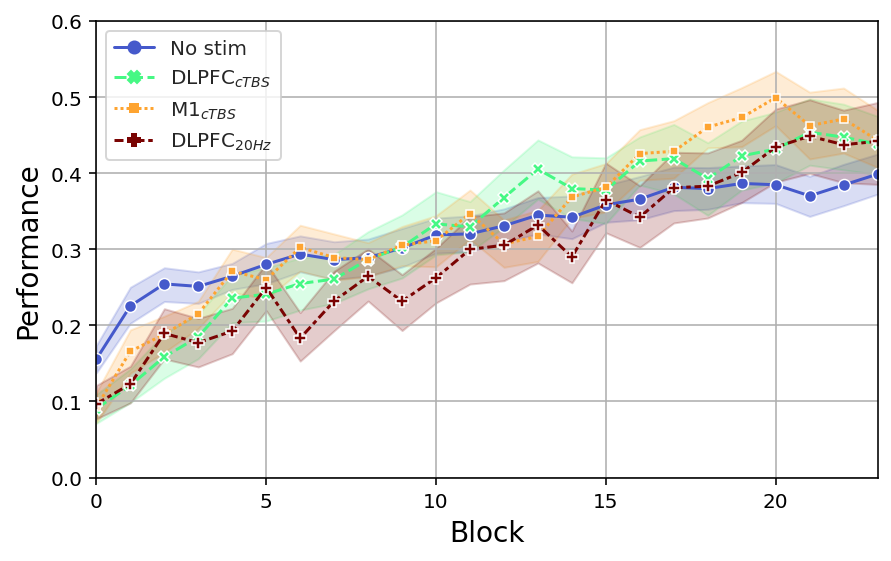

In [19]:
fig, ax = plt.subplots(figsize=(7, 4.2))
# fig.set_size_inches(7, 4.2)
# plt.rcParams['font.size'] = '12'

sns.set_style("whitegrid")

g = sns.lineplot(
    data=df, x='block', y='reward', hue='group'
    , style='group', dashes=True, markers=True
    , ci=68
    , palette=palette
    , ax=ax
)

g.legend()
g.grid(True, which='major', axis='both')
g.set_ylim(0, .6)
g.set_ylabel('Performance', fontsize=14)
g.set_xlim(0, 23)
g.set_xlabel('Block', fontsize=14)
# # ax.set_xticklabels([1,5,9,13,17,21,24])

In [19]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/behav.learning_curve.GA_vs_GP.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)

## boxplot

In [20]:
dg = df[df.block<5]

Text(0, 0.5, 'Performance')

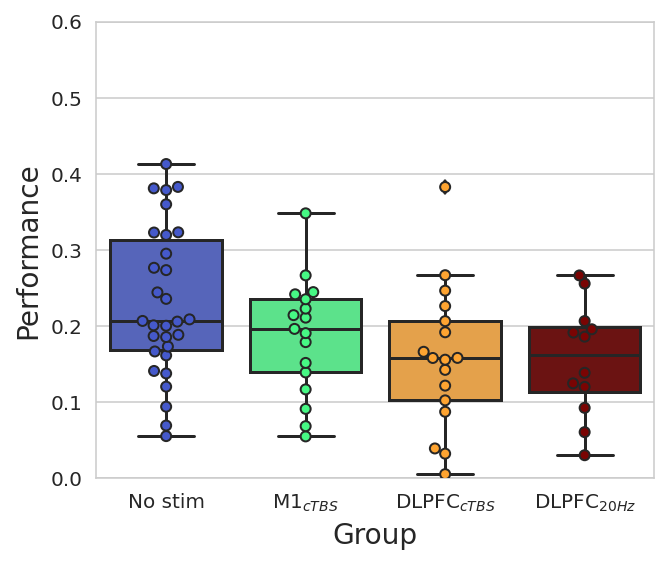

In [21]:
fig, ax = plt.subplots(figsize=(5, 4.2))

dh = dg.groupby(['subj', 'group'], as_index=False).mean()
sns.swarmplot(
    data=dh
    , x='group', y='reward'
    , size=5, palette=palette, linewidth=1
    , ax=ax
)
g = sns.boxplot(
    data=dh
    , x='group', y='reward'
    , palette=palette
    , ax=ax
)
g.set_ylim(0.,0.6)
g.set_xlabel('Group', fontsize=14)
g.set_ylabel('Performance', fontsize=14)

In [22]:
for ii, g1 in enumerate(dh.group.unique()):
    x1 = ii
    for jj, g2 in enumerate(dh.group.unique()[ii+1:]):
        x2 = ii+1+jj
        a = dh[dh.group==g1].reward
        b = dh[dh.group==g2].reward
        _, pval = stats.ttest_ind(a,b)
        print('(%d,%d)'%(x1,x2), convert_pvalue_to_asterisks(pval))

(0,1) ns
(0,2) *
(0,3) *
(1,2) ns
(1,3) ns
(2,3) ns


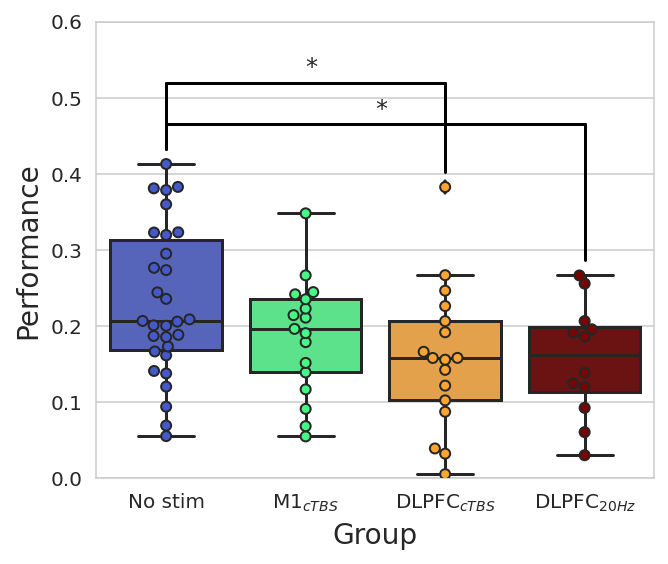

In [23]:
y = {}
y[(0,2)] = 0.52
y[(0,3)] = 0.465
dy = 0.02
for ii, g1 in enumerate(dh.group.unique()):
    x1 = ii
    for jj, g2 in enumerate(dh.group.unique()[ii+1:]):
        x2 = ii+1+jj
        a = dh[dh.group==g1].reward
        b = dh[dh.group==g2].reward
        _, pval = stats.ttest_ind(a,b)
        if pval>0.05:
            continue
        
        y1 = a.max()+dy
        y2 = b.max()+dy
        ytext = y[(x1,x2)]
        g.plot([x1,x1],[y1,ytext], 'k-')
        g.plot([x2,x2],[y2,ytext], 'k-')
        g.plot([x1,x2],[ytext,ytext],'k-')
        g.text((x1+x2)*0.5, ytext+0.01, convert_pvalue_to_asterisks(pval), fontsize=12)
fig

In [24]:
g.get_children()

 Text(1.0, 0.53, '*'),
 Text(1.5, 0.47500000000000003, '*'),
 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

In [25]:
g.get_children()[6].get_bbox()

Bbox([[0.0, 0.313625], [0.0, 0.4129444444444445]])

In [26]:
fig.savefig(
    '/home/sungbeenpark/Github/labs/GP/results/behav.boxplot.GA_vs_GP.png'
    , dpi=300, facecolor=[1,1,1,1]
    , bbox_inches = "tight"
)